# Country2Country Citation Relations

In [45]:
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

Set up the API call. The base URL is filtering the OpenAlex corpus for works by authors with affiliations from one or more countries (*country_codes_1*) and coauthors from one or more countries (*country_codes_2*). The variable *years* is being used to define the timeframe in which the works are published in.

In [ ]:
# Define the base URL for the API
base_url = "https://api.openalex.org/works?filter=institutions.country_code:{},institutions.country_code:{},publication_year:"

# List of values for "country_code_1"
country_codes_1 = ["ua"]  # Replace with your specific values

# List of values for "country_code_2"
country_codes_2 = ["de", "pl", "ua", "in", "nl", "us"]  # Replace with your specific values

# List of years to iterate through
years = list(range(2017, 2024))

# List to store the retrieved metadata counts
metadata_counts = []

# Iterate through the lists of "country_code_1", "country_code_2", and years
for code_1 in country_codes_1:
    for code_2 in country_codes_2:
        for year in years:
            # Create the API URL with the variables
            api_url = base_url.format(code_1, code_2) + str(year)

            # Make the API request
            response = requests.get(api_url)

            # Check if the response is successful (status code 200)
            if response.status_code == 200:
                data = response.json()
                
                # Get the count from the response
                count = data["meta"]["count"]
                
                # Append the country, year, and count to the list
                metadata_counts.append({"Country": f"{code_1} to {code_2}", "Year": year, "Count": count})

# Create a DataFrame from the metadata counts
metadata_df = pd.DataFrame(metadata_counts)

In the next step, the harvested data is put in a dataframe.

In [48]:
# Create DataFrames for each year with the required columns
yearly_dfs = []
for year in years:
    # Filter metadata_df for the specific year
    year_df = metadata_df[metadata_df["Year"] == year]

    # Create a DataFrame with columns "source," "target," and "weight"
    edges_df = pd.DataFrame({
        "source": year_df["Country"].apply(lambda x: x.split(" to ")[0]),
        "target": year_df["Country"].apply(lambda x: x.split(" to ")[1]),
        "weight": year_df["Count"]
    })

    # Append the DataFrame to the list
    yearly_dfs.append(edges_df)

# Print the resulting DataFrames for each year
for idx, year_df in enumerate(yearly_dfs):
    print(f"\nDataFrame for Year {years[idx]}:")
    print(year_df)


DataFrame for Year 2017:
   source target  weight
0      ua     de     671
7      ua     pl    1016
14     ua     ua   19422
21     ua     in     107
28     ua     nl      81
35     ua     us     749

DataFrame for Year 2018:
   source target  weight
1      ua     de     726
8      ua     pl    1156
15     ua     ua   24041
22     ua     in     114
29     ua     nl      84
36     ua     us     784

DataFrame for Year 2019:
   source target  weight
2      ua     de     807
9      ua     pl    1354
16     ua     ua   30650
23     ua     in     111
30     ua     nl     141
37     ua     us     914

DataFrame for Year 2020:
   source target  weight
3      ua     de     833
10     ua     pl    1383
17     ua     ua   36949
24     ua     in     163
31     ua     nl     137
38     ua     us    1034

DataFrame for Year 2021:
   source target  weight
4      ua     de     846
11     ua     pl    1494
18     ua     ua   36758
25     ua     in     248
32     ua     nl     148
39     ua     us    

A first visualization: A simple bar chart of the counts of works

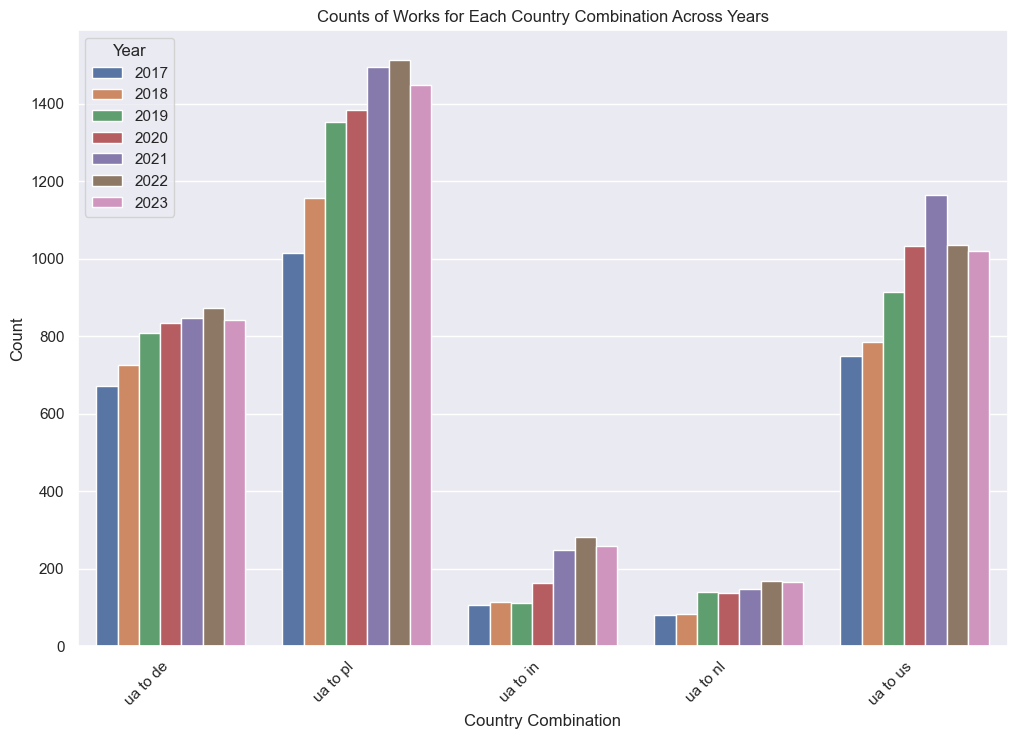

In [49]:
# Change style to dark background
sns.set(style="darkgrid")

# Filter out rows where both countries are the same
filtered_metadata_df = metadata_df[metadata_df['Country'].apply(lambda x: x.split(' to ')[0] != x.split(' to ')[1])]

# Create a bar plot
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x="Country", y="Count", hue="Year", data=filtered_metadata_df)
bar_plot.set_title('Counts of Works for Each Country Combination Across Years')
bar_plot.set_xlabel('Country Combination')
bar_plot.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

Next step: Creating a network with a directed graph. Work in progress.

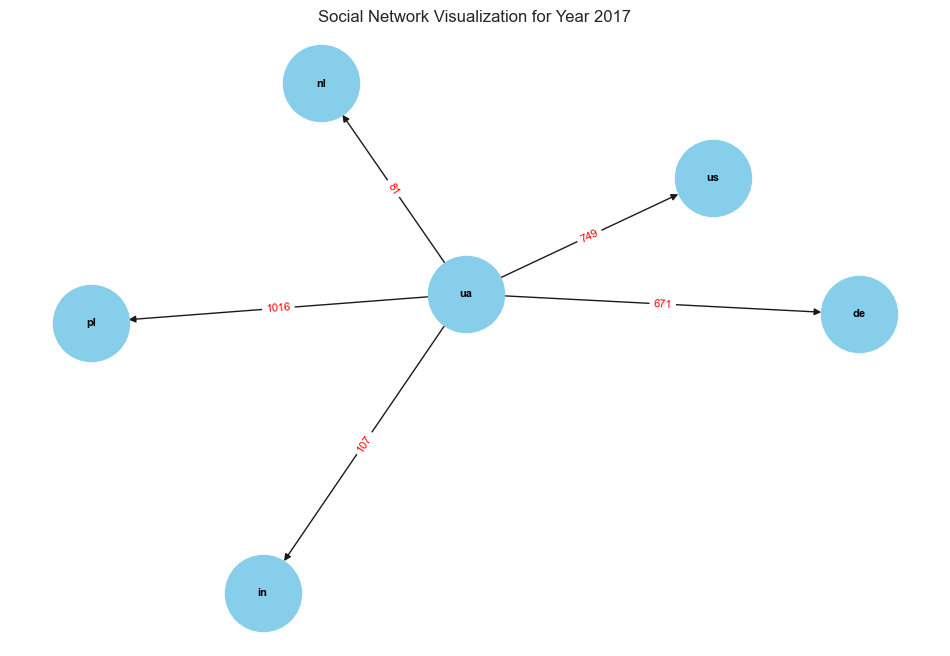

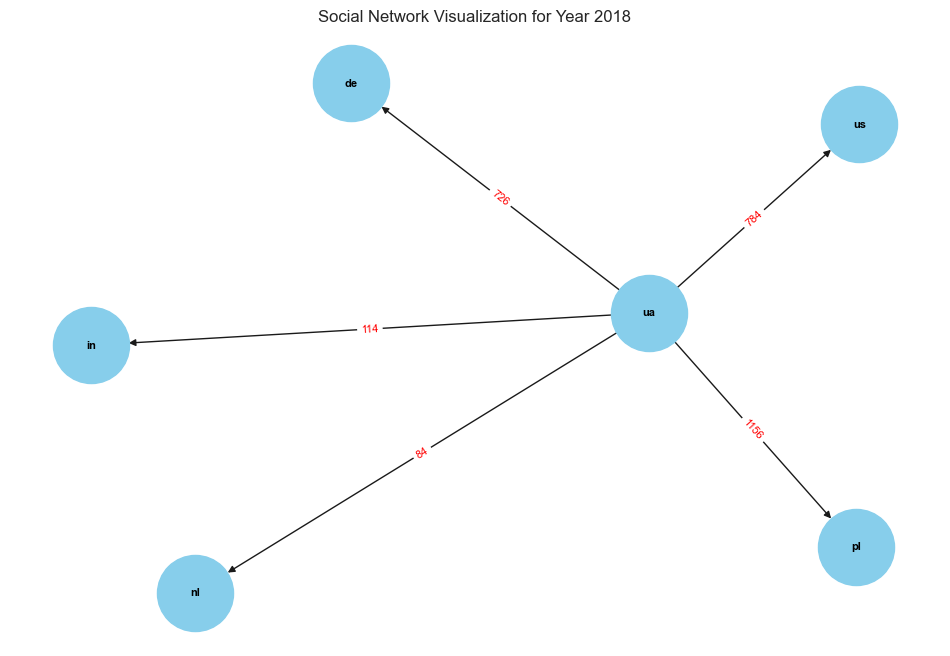

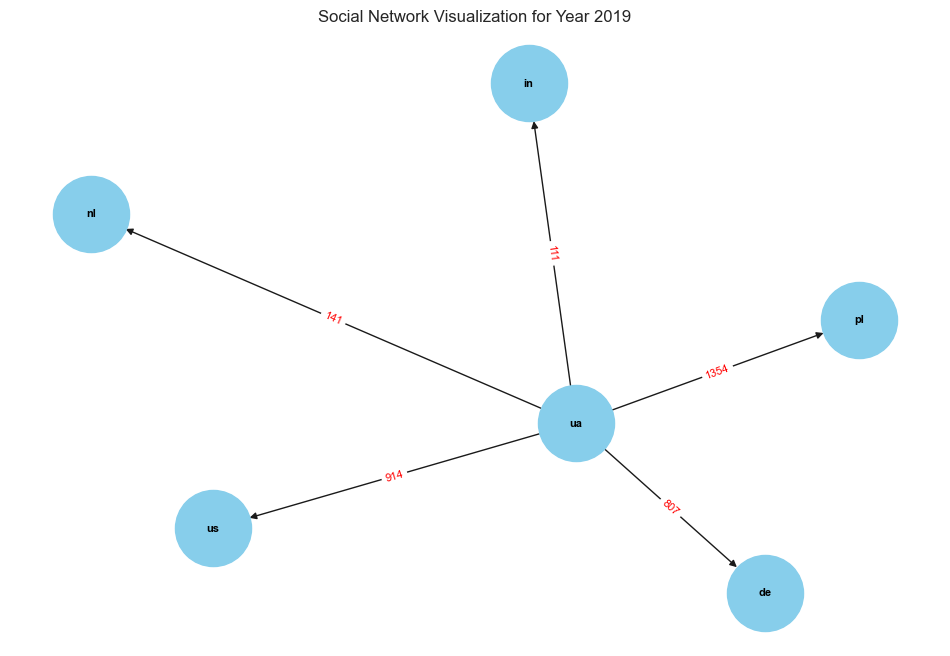

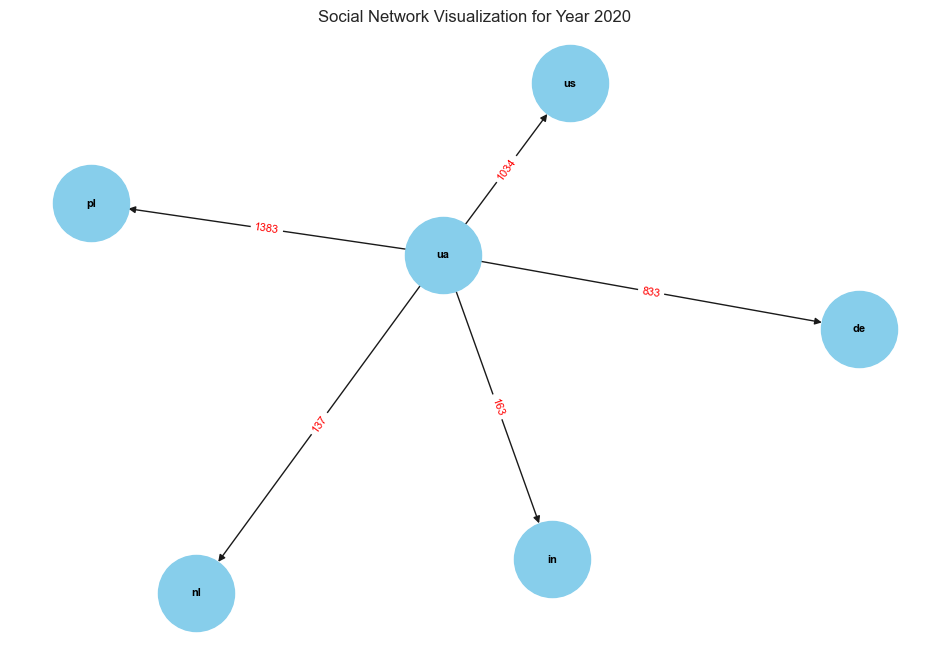

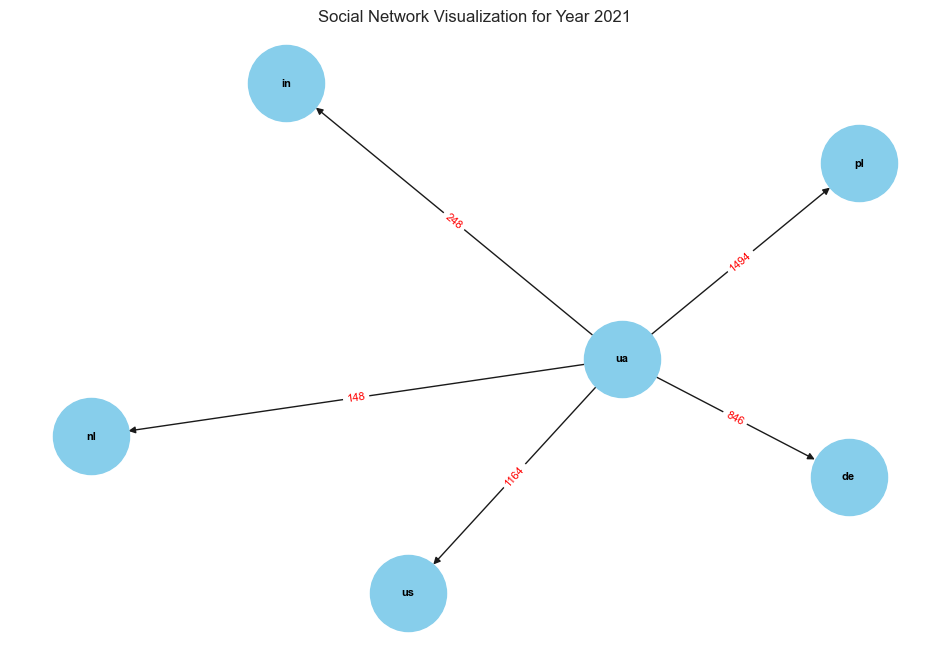

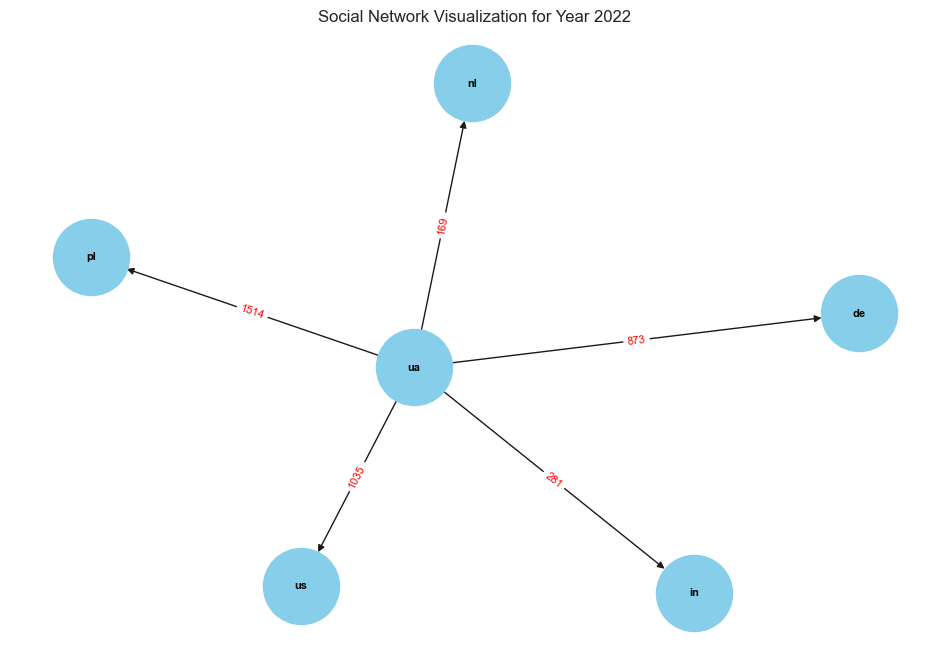

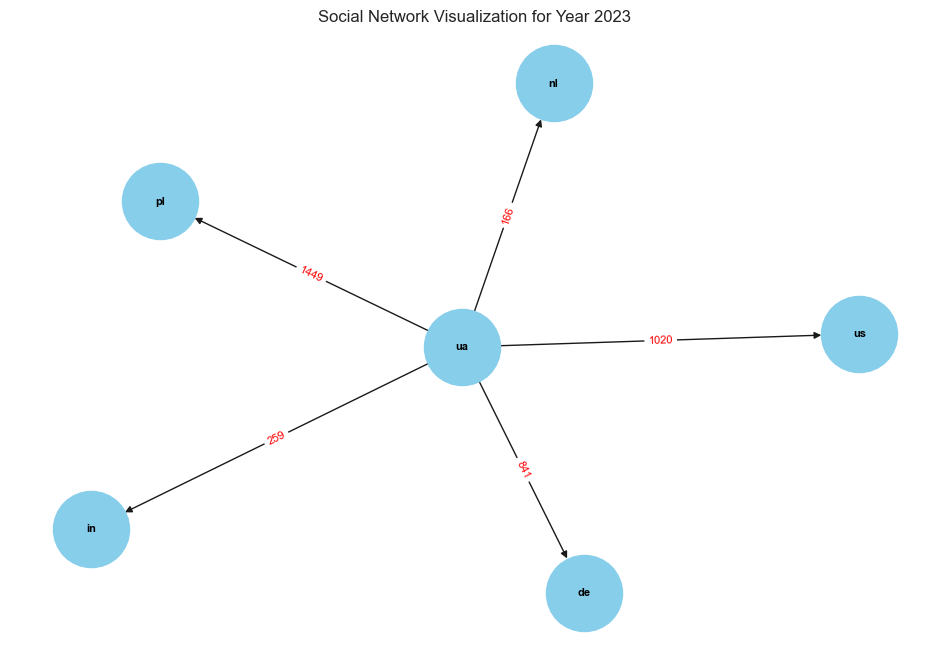

In [50]:
# Create a network visualization for each year
for year in years:
    # Extract edges and weights for the specific year
    year_df = metadata_df[metadata_df['Year'] == year]
    edges = [(row['Country'].split(' to ')[0], row['Country'].split(' to ')[1]) for _, row in year_df.iterrows()]
    weights = {tuple(row['Country'].split(' to ')): row['Count'] for _, row in year_df.iterrows()}

    # Create a directed graph
    G = nx.DiGraph()

    # Ad edges to the graph based on metadata_df
    for _, row in year_df.iterrows():
        source = row['Country'].split(' to ')[0]
        target = row['Country'].split(' to ')[1]
        weight = row['Count']

        # Remove connections from a node to itself
        if source != target:
            G.add_edge(source, target, weight=weight)

    # Plot the graph
    plt.figure(figsize=(12, 8))
    plt.title(f'Social Network Visualization for Year {year}')

    # Draw the network within the new figure, specifying the ax parameter
    pos = nx.spring_layout(G)
    ax = plt.gca()  # Get the current axes
    nx.draw(G, pos, with_labels=True, font_size=8, node_size=3000, node_color='skyblue', font_color='black', font_weight='bold', ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_color='red', font_size=8)

    # Show the plot
    plt.show()


Try a markov chain to prepare the prediction calculation. Work in progress. And maybe a dead end.

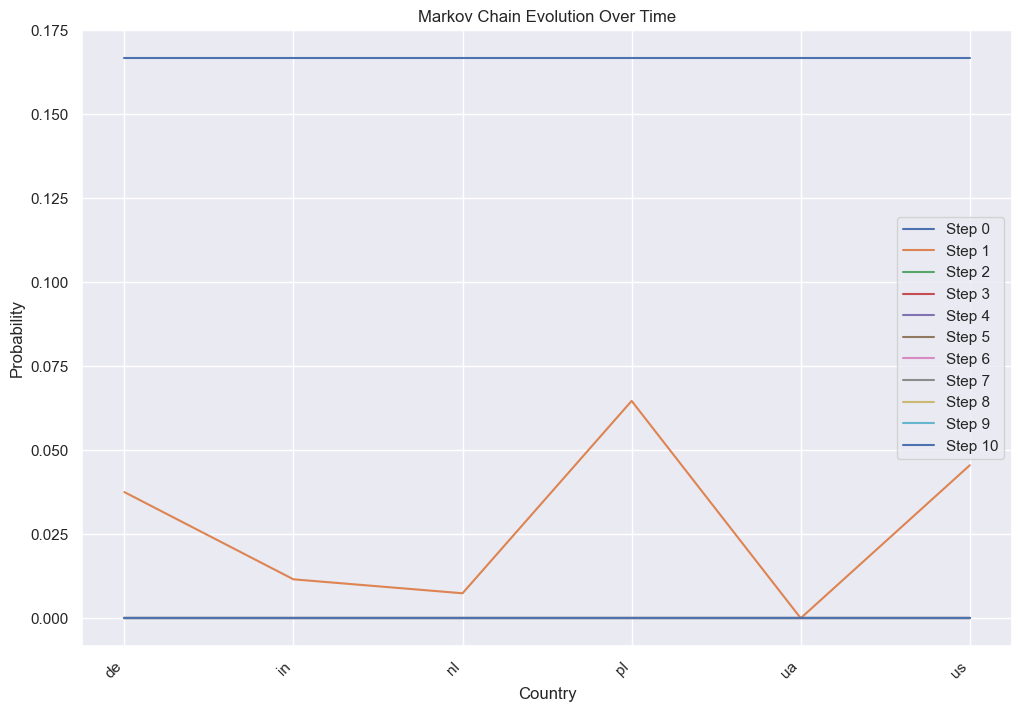

In [51]:
# Create a list of countries
countries = sorted(set(G.nodes()))

# Create a Markov transition matrix
transition_matrix = np.zeros((len(countries), len(countries)))

for source in countries:
    neighbors = list(G.successors(source))
    total_weight = sum(G[source][neighbor]['weight'] for neighbor in neighbors)
    
    for target in countries:
        if source != target:
            transition_probability = G[source][target]['weight'] / total_weight if total_weight > 0 else 0
            transition_matrix[countries.index(source)][countries.index(target)] = transition_probability

# Simulate Markov chain for a certain number of steps
num_steps = 10
current_state = np.ones(len(countries)) / len(countries)  # Initial state is uniform

# Store the states at each step
states_over_time = [current_state.copy()]

for _ in range(num_steps):
    current_state = np.dot(current_state, transition_matrix)
    states_over_time.append(current_state)

# Visualize the Markov chain evolution
plt.figure(figsize=(12, 8))
plt.title('Markov Chain Evolution Over Time')
plt.xlabel('Country')
plt.ylabel('Probability')
for i, state in enumerate(states_over_time):
    plt.plot(range(len(countries)), state, label=f'Step {i}')

plt.xticks(range(len(countries)), countries, rotation=45, ha='right')
plt.legend()
plt.show()


In [ ]:
Another try.

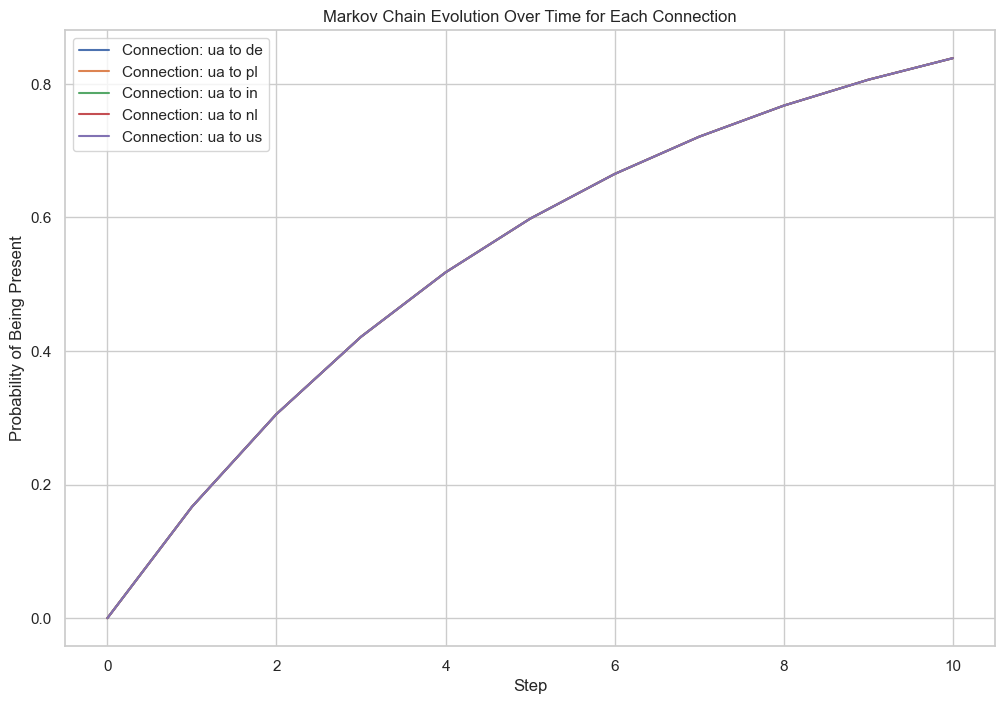

In [44]:
# Create a list of unique source-to-target connections
connections = [(source, target) for source, target, _ in G.edges(data=True)]

# Create a dictionary to store transition matrices for each connection
transition_matrices = {}

# Populate transition matrices for each connection
for source, target in connections:
    transition_matrix = np.zeros((2, 2))  # Assuming a binary state (present or not)

    # Find occurrences of the connection in metadata_df
    connection_data = metadata_df[(metadata_df['Country'].str.startswith(source)) & (metadata_df['Country'].str.endswith(target))]

    # Populate the transition matrix based on historical data
    for year in sorted(set(connection_data['Year'])):
        year_data = connection_data[connection_data['Year'] == year]
        present_count = len(year_data)
        total_count = len(metadata_df[metadata_df['Year'] == year])

        # Transition probabilities
        p_stays = 1 - (present_count / total_count)
        p_appears = present_count / total_count

        transition_matrix[0, 0] = p_stays
        transition_matrix[0, 1] = p_appears
        transition_matrix[1, 0] = 0  # Assumes once present, it stays
        transition_matrix[1, 1] = 1  # Assumes once present, it stays

    transition_matrices[(source, target)] = transition_matrix

# Simulate Markov chain for a certain number of steps for each connection
num_steps = 10

# Store the states at each step for each connection
states_over_time = np.zeros((num_steps + 1, len(connections)))

for i, (source, target) in enumerate(connections):
    transition_matrix = transition_matrices[(source, target)]
    current_state = np.array([1, 0])  # Initial state: not present

    for step in range(num_steps):
        current_state = np.dot(current_state, transition_matrix)
        states_over_time[step + 1, i] = current_state[1]  # Probability of being present

# Visualize the Markov chain evolution for each connection
plt.figure(figsize=(12, 8))
plt.title('Markov Chain Evolution Over Time for Each Connection')
plt.xlabel('Step')
plt.ylabel('Probability')

for i, (source, target) in enumerate(connections):
    plt.plot(range(num_steps + 1), states_over_time[:, i], label=f'Connection: {source} to {target}')

plt.legend()
plt.show()


Here be dragons.